In [1]:
import logging
import os

working_dir = "/global/cfs/cdirs/m4581/lee1043/work/cdat/pmp/mean_climate/mean_climate_workflow_refactorization/output"

logging.basicConfig(filename=os.path.join(working_dir, 'error_log.txt'), level=logging.ERROR, filemode='w',
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [2]:
from pcmdi_metrics.mean_climate.lib_unified import (
    get_unique_bases, process_dataset, calculate_and_save_metrics, extract_info_from_model_catalogue, 
    get_ref_catalogue, get_model_catalogue, 
    multi_level_dict, print_dict, write_to_json
)
import os
import datetime


from pcmdi_metrics.utils import create_target_grid

In [3]:
"""
variables = [
    "pr", "psl", 
    "ua-200", "ua-850", "va-200", "ta-850",
    "rsdt", "rsut", "rsutcs", "rlut", "rlutcs", 
    "rstcre", "rltcre", "rt", "rst"
]  # optional. If given, prioritized over the model_catalogue.json. If not given, use all variables commonly in ref_catalogue.json and model_catalogue.json

#variables = [
#    "ua-200", "ua-850", "va-200"
#]

#variables = ["psl"]
"""

model_data_path_template = "/home/data/%(model)/%(var)/%(model)_%(run)_%(var)_blabla.nc"  # optional. If given, prioritized over model_catalogue.json

models = ["model-a", "model-b"]  # optional. If given, prioritized over the model_catalogue.json. If not given, use all models in model_catalogue.json

models_runs_dict = {
    "model-a": ["r1", "r2"],
    "model-b": ["r1", "r2"],
    "model-c": ["r1", "r2"],
}
# optional. If given, prioritized over the model_catalogue.json. If not given, use all runs in model_catalogue.json

In [4]:
output_path = "/global/cfs/cdirs/m4581/lee1043/work/cdat/pmp/mean_climate/mean_climate_workflow_refactorization/output/json"

regions = ["NHEX", "SHEX"]

target_grid = "2.5x2.5"

ref_catalogue_file_path = '/global/cfs/projectdirs/m4581/obs4MIPs/catalogue/obs4MIPs_PCMDI_monthly_byVar_catalogue_v20250825.json'
model_catalogue_file_path = 'model_catalogue.json'

ref_data_head = "/global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL"  # optional, if ref_catalogue file does not include entire directory path


In [5]:
rad_diagnostic_variables = ["rt", "rst", "rstcre", "rltcre"]

default_regions = ["global", "NHEX", "SHEX", "TROPICS"]

In [6]:
if not regions:
    regions = default_regions

In [7]:
refs_dict = get_ref_catalogue(ref_catalogue_file_path, ref_data_head)
variables = sorted(list(refs_dict.keys()))

variables

['hfls',
 'hfns',
 'hfss',
 'hur',
 'hus',
 'pr',
 'prw',
 'psl',
 'rlds',
 'rldscs',
 'rltcre',
 'rlus',
 'rlut',
 'rlutcs',
 'rsds',
 'rsdscs',
 'rsdt',
 'rstcre',
 'rsus',
 'rsuscs',
 'rsut',
 'rsutcs',
 'rt',
 'sfcWind',
 'ta',
 'tas',
 'tasmax',
 'tasmin',
 'tauu',
 'tauv',
 'ts',
 'ua',
 'uas',
 'va',
 'vas',
 'zg',
 'zos']

In [8]:
models_dict = get_model_catalogue(model_catalogue_file_path, variables, models, models_runs_dict, model_data_path_template)

In [9]:
import glob

In [10]:
era5_files = glob.glob("/global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/ECMWF/ERA-5/mon/*/gn/latest/*.nc")

In [11]:
# List of files (replace this with your full list of files)
files = era5_files

# Initialize an empty dictionary to group files
grouped_files = {}

# Loop through each file path
for file in files:
    # Extract the variable name (e.g., vas, va, tas, etc.)
    variable = file.split('/')[-1].split('_')[0]
    
    # Extract the dataset name (e.g., ERA-5)
    dataset = file.split('/')[8]
    
    # Construct the template path with wildcard for the time range
    template = '/'.join(file.split('/')[:-1]) + f'/{variable}_mon_{dataset}_PCMDI_gn_*.nc'
    
    # Add to the dictionary
    if variable not in grouped_files:
        grouped_files[variable] = {}
    if dataset not in grouped_files[variable]:
        grouped_files[variable][dataset] = {"template": template}

# Print the resulting dictionary
import json
print(json.dumps(grouped_files, indent=4))

{
    "vas": {
        "ERA-5": {
            "template": "/global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/ECMWF/ERA-5/mon/vas/gn/latest/vas_mon_ERA-5_PCMDI_gn_*.nc"
        }
    },
    "uas": {
        "ERA-5": {
            "template": "/global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/ECMWF/ERA-5/mon/uas/gn/latest/uas_mon_ERA-5_PCMDI_gn_*.nc"
        }
    },
    "va": {
        "ERA-5": {
            "template": "/global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/ECMWF/ERA-5/mon/va/gn/latest/va_mon_ERA-5_PCMDI_gn_*.nc"
        }
    },
    "tas": {
        "ERA-5": {
            "template": "/global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/ECMWF/ERA-5/mon/tas/gn/latest/tas_mon_ERA-5_PCMDI_gn_*.nc"
        }
    },
    "ua": {
        "ERA-5": {
            "template": "/global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/ECMWF/ERA-5/mon/ua/gn/latest/ua_mon_ERA-5_PCMDI_gn_*.nc"
        }
    },
    "ta": {
        "ERA-5": {
            "template": "/global/cfs/projec

In [12]:
era5_vars = sorted(list(grouped_files.keys()))

In [13]:
if any(var is None for var in (variables, models, models_runs_dict)): 
    variables, models, models_runs_dict = extract_info_from_model_catalogue(variables, models, models_runs_dict, refs_dict, models_dict)

In [14]:
common_grid = create_target_grid(target_grid_resolution=target_grid)

variables_unique: ['hfls', 'hfns', 'hfss', 'hur', 'hus', 'pr', 'prw', 'psl', 'rlds', 'rldscs', 'rltcre', 'rlus', 'rlut', 'rlutcs', 'rsds', 'rsdscs', 'rsdt', 'rstcre', 'rsus', 'rsuscs', 'rsut', 'rsutcs', 'rt', 'sfcWind', 'ta', 'tas', 'tasmax', 'tasmin', 'tauu', 'tauv', 'ts', 'ua', 'uas', 'va', 'vas', 'zg', 'zos']
variables_level_dict: {'hfls': [None], 'hfns': [None], 'hfss': [None], 'hur': [None], 'hus': [None], 'pr': [None], 'prw': [None], 'psl': [None], 'rlds': [None], 'rldscs': [None], 'rltcre': [None], 'rlus': [None], 'rlut': [None], 'rlutcs': [None], 'rsds': [None], 'rsdscs': [None], 'rsdt': [None], 'rstcre': [None], 'rsus': [None], 'rsuscs': [None], 'rsut': [None], 'rsutcs': [None], 'rt': [None], 'sfcWind': [None], 'ta': [None], 'tas': [None], 'tasmax': [None], 'tasmin': [None], 'tauu': [None], 'tauv': [None], 'ts': [None], 'ua': [None], 'uas': [None], 'va': [None], 'vas': [None], 'zg': [None], 'zos': [None]}
version: v20250825
var: pr
levels: [None]
=== var, ref: pr, CMAP-V1902
P

2025-08-25 15:48:57,161 [ERROR]: 3100435006.py(process_references:46) >> Error for pr CMAP-V1902: failed to prevent overwriting existing key calendar in attrs on variable 'time'. This is probably an encoding field used by xarray to describe how a variable is serialized. To proceed, remove this key from the variable's attributes manually.


outdir: /global/cfs/projectdirs/m4581/PMP/pmp_reference/obs4MIPs_clims_1980-2014/pr/gn/v20250825
start: 1980-01-01
end: 2014-12-01
outdir, outfilename, outfile: /global/cfs/projectdirs/m4581/PMP/pmp_reference/obs4MIPs_clims_1980-2014/pr/gn/v20250825 pr_mon_CMAP-V1902_PCMDI_gn_%(start-yyyymm)-%(end-yyyymm)_%(season)_v20250825.nc None
Error logged for pr CMAP-V1902
Error from process_references for pr CMAP-V1902: failed to prevent overwriting existing key calendar in attrs on variable 'time'. This is probably an encoding field used by xarray to describe how a variable is serialized. To proceed, remove this key from the variable's attributes manually.
=== var, ref: pr, ERA-INT
Processing data for: ERA-INT
jwlee123, ref, data_path: ERA-INT /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/ECMWF/ERA-INT/mon/pr/gn/v20210727/pr_mon_ERA-INT_PCMDI_gn_197901-201903.nc
Processing ref dataset - varname: pr, data: ERA-INT, path: /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/ECMWF/ERA-INT/

2025-08-25 15:49:16,068 [ERROR]: 3100435006.py(process_references:46) >> Error for pr ERA-INT: local variable 'levels_to_plot' referenced before assignment


regrid done, ds_ac_interp[pr].shape: (12, 72, 144)
data_var, da.shape: pr (12, 72, 144)
Error logged for pr ERA-INT
Error from process_references for pr ERA-INT: local variable 'levels_to_plot' referenced before assignment
=== var, ref: pr, GPCP-2-3
Processing data for: GPCP-2-3
jwlee123, ref, data_path: GPCP-2-3 /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/NOAA-NCEI/GPCP-2-3/mon/pr/gn/v20210727/pr_mon_GPCP-2-3_PCMDI_gn_197901-201907.nc
Processing ref dataset - varname: pr, data: GPCP-2-3, path: /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/NOAA-NCEI/GPCP-2-3/mon/pr/gn/v20210727/pr_mon_GPCP-2-3_PCMDI_gn_197901-201907.nc
ver: v20250825
ver: v20250825
get_annual_cycle, var: pr
data_path: /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/NOAA-NCEI/GPCP-2-3/mon/pr/gn/v20210727/pr_mon_GPCP-2-3_PCMDI_gn_197901-201907.nc
out_path: /global/cfs/projectdirs/m4581/PMP/pmp_reference/obs4MIPs_clims_1980-2014/pr/gn
outfilename_head: pr_mon_GPCP-2-3_PCMDI_gn
outfilename_template: pr

2025-08-25 15:49:22,229 [ERROR]: 3100435006.py(process_references:46) >> Error for pr GPCP-2-3: local variable 'levels_to_plot' referenced before assignment


Successfully saved climatology for season 'DJF' to /global/cfs/projectdirs/m4581/PMP/pmp_reference/obs4MIPs_clims_1980-2014/pr/gn/v20250825/pr_mon_GPCP-2-3_PCMDI_gn_198001-201412_DJF_v20250825.nc
Successfully saved climatology for season 'MAM' to /global/cfs/projectdirs/m4581/PMP/pmp_reference/obs4MIPs_clims_1980-2014/pr/gn/v20250825/pr_mon_GPCP-2-3_PCMDI_gn_198001-201412_MAM_v20250825.nc
Successfully saved climatology for season 'JJA' to /global/cfs/projectdirs/m4581/PMP/pmp_reference/obs4MIPs_clims_1980-2014/pr/gn/v20250825/pr_mon_GPCP-2-3_PCMDI_gn_198001-201412_JJA_v20250825.nc
Successfully saved climatology for season 'SON' to /global/cfs/projectdirs/m4581/PMP/pmp_reference/obs4MIPs_clims_1980-2014/pr/gn/v20250825/pr_mon_GPCP-2-3_PCMDI_gn_198001-201412_SON_v20250825.nc
regrid starts
regrid done, ds_ac_interp[pr].shape: (12, 72, 144)
data_var, da.shape: pr (12, 72, 144)
Error logged for pr GPCP-2-3
Error from process_references for pr GPCP-2-3: local variable 'levels_to_plot' refere

2025-08-25 15:50:26,625 [ERROR]: 3100435006.py(process_references:46) >> Error for pr GPCP-Monthly-3-2: local variable 'levels_to_plot' referenced before assignment


regrid done, ds_ac_interp[pr].shape: (12, 72, 144)
data_var, da.shape: pr (12, 72, 144)
Error logged for pr GPCP-Monthly-3-2
Error from process_references for pr GPCP-Monthly-3-2: local variable 'levels_to_plot' referenced before assignment
=== var, ref: pr, IMERG-V07-Final
Processing data for: IMERG-V07-Final
jwlee123, ref, data_path: IMERG-V07-Final /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/NASA-GSFC/IMERG-V07-Final/mon/pr/gn/v20240515/pr_mon_IMERG-V07-Final_RSS_gn_*.nc
Processing ref dataset - varname: pr, data: IMERG-V07-Final, path: /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/NASA-GSFC/IMERG-V07-Final/mon/pr/gn/v20240515/pr_mon_IMERG-V07-Final_RSS_gn_*.nc
ver: v20250825
ver: v20250825
get_annual_cycle, var: pr
data_path: /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/NASA-GSFC/IMERG-V07-Final/mon/pr/gn/v20240515/pr_mon_IMERG-V07-Final_RSS_gn_*.nc
out_path: /global/cfs/projectdirs/m4581/PMP/pmp_reference/obs4MIPs_clims_1980-2014/pr/gn
outfilename_head: pr_

2025-08-25 15:55:30,959 [ERROR]: 3100435006.py(process_references:46) >> Error for pr IMERG-V07-Final: local variable 'levels_to_plot' referenced before assignment


regrid done, ds_ac_interp[pr].shape: (12, 72, 144)
data_var, da.shape: pr (12, 72, 144)
Error logged for pr IMERG-V07-Final
Error from process_references for pr IMERG-V07-Final: local variable 'levels_to_plot' referenced before assignment
=== var, ref: pr, IMERG-v06B-Final
Processing data for: IMERG-v06B-Final
jwlee123, ref, data_path: IMERG-v06B-Final /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/NASA-GSFC/IMERG-v06B-Final/mon/pr/gn/v20240408/pr_mon_IMERG-v06B-Final_RSS_gn_200101-200101.nc
Processing ref dataset - varname: pr, data: IMERG-v06B-Final, path: /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/NASA-GSFC/IMERG-v06B-Final/mon/pr/gn/v20240408/pr_mon_IMERG-v06B-Final_RSS_gn_200101-200101.nc
ver: v20250825
ver: v20250825
get_annual_cycle, var: pr
data_path: /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/NASA-GSFC/IMERG-v06B-Final/mon/pr/gn/v20240408/pr_mon_IMERG-v06B-Final_RSS_gn_200101-200101.nc
out_path: /global/cfs/projectdirs/m4581/PMP/pmp_reference/obs4MIPs

2025-08-25 15:55:50,616 [ERROR]: 3100435006.py(process_references:46) >> Error for pr IMERG-v06B-Final: failed to prevent overwriting existing key calendar in attrs on variable 'time'. This is probably an encoding field used by xarray to describe how a variable is serialized. To proceed, remove this key from the variable's attributes manually.


Error logged for pr IMERG-v06B-Final
Error from process_references for pr IMERG-v06B-Final: failed to prevent overwriting existing key calendar in attrs on variable 'time'. This is probably an encoding field used by xarray to describe how a variable is serialized. To proceed, remove this key from the variable's attributes manually.
=== var, ref: pr, MSWEP-V280-Past
Processing data for: MSWEP-V280-Past
jwlee123, ref, data_path: MSWEP-V280-Past /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/GloH2O/MSWEP-V280-Past/mon/pr/10km/v20240514/pr_mon_MSWEP-V280-Past_PCMDI_10km_198012-198112.nc
Processing ref dataset - varname: pr, data: MSWEP-V280-Past, path: /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/GloH2O/MSWEP-V280-Past/mon/pr/10km/v20240514/pr_mon_MSWEP-V280-Past_PCMDI_10km_198012-198112.nc
ver: v20250825
ver: v20250825
get_annual_cycle, var: pr
data_path: /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/GloH2O/MSWEP-V280-Past/mon/pr/10km/v20240514/pr_mon_MSWEP-V280-Past_

2025-08-25 15:56:12,665 [ERROR]: 3100435006.py(process_references:46) >> Error for pr MSWEP-V280-Past: More than one grid cell spans prime meridian.


Error logged for pr MSWEP-V280-Past
Error from process_references for pr MSWEP-V280-Past: More than one grid cell spans prime meridian.
=== var, ref: pr, MSWEP-V280-Past-nogauge
Processing data for: MSWEP-V280-Past-nogauge
jwlee123, ref, data_path: MSWEP-V280-Past-nogauge /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/GloH2O/MSWEP-V280-Past-nogauge/mon/pr/10km/v20240514/pr_mon_MSWEP-V280-Past-nogauge_PCMDI_10km_198101-198112.nc
Processing ref dataset - varname: pr, data: MSWEP-V280-Past-nogauge, path: /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/GloH2O/MSWEP-V280-Past-nogauge/mon/pr/10km/v20240514/pr_mon_MSWEP-V280-Past-nogauge_PCMDI_10km_198101-198112.nc
ver: v20250825
ver: v20250825
get_annual_cycle, var: pr
data_path: /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/GloH2O/MSWEP-V280-Past-nogauge/mon/pr/10km/v20240514/pr_mon_MSWEP-V280-Past-nogauge_PCMDI_10km_198101-198112.nc
out_path: /global/cfs/projectdirs/m4581/PMP/pmp_reference/obs4MIPs_clims_1980-2014/pr/gn
o

2025-08-25 15:56:32,287 [ERROR]: 3100435006.py(process_references:46) >> Error for pr MSWEP-V280-Past-nogauge: More than one grid cell spans prime meridian.


Error logged for pr MSWEP-V280-Past-nogauge
Error from process_references for pr MSWEP-V280-Past-nogauge: More than one grid cell spans prime meridian.
=== var, ref: pr, PRISM-M3
Processing data for: PRISM-M3
jwlee123, ref, data_path: PRISM-M3 /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/OSU/PRISM-M3/mon/pr/gn/v20230612/pr_mon_PRISM-M3_PCMDI_gn_198101-200512.nc
Processing ref dataset - varname: pr, data: PRISM-M3, path: /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/OSU/PRISM-M3/mon/pr/gn/v20230612/pr_mon_PRISM-M3_PCMDI_gn_198101-200512.nc
ver: v20250825
ver: v20250825
get_annual_cycle, var: pr
data_path: /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/OSU/PRISM-M3/mon/pr/gn/v20230612/pr_mon_PRISM-M3_PCMDI_gn_198101-200512.nc
out_path: /global/cfs/projectdirs/m4581/PMP/pmp_reference/obs4MIPs_clims_1980-2014/pr/gn
outfilename_head: pr_mon_PRISM-M3_PCMDI_gn
outfilename_template: pr_mon_PRISM-M3_PCMDI_gn_%(start-yyyymm)-%(end-yyyymm)_%(season)_v20250825.nc
ver: v2025082

/global/homes/l/lee1043/.conda/envs/pmp_devel_20250722/lib/python3.10/site-packages/xcdat/regridder/regrid2.py:223: RuntimeWarning: invalid value encountered in divide
  np.divide(
2025-08-25 15:57:11,602 [ERROR]: 3100435006.py(process_references:46) >> Error for pr PRISM-M3: local variable 'levels_to_plot' referenced before assignment


regrid done, ds_ac_interp[pr].shape: (12, 72, 144)
data_var, da.shape: pr (12, 72, 144)
Error logged for pr PRISM-M3
Error from process_references for pr PRISM-M3: local variable 'levels_to_plot' referenced before assignment
=== var, ref: pr, TRMM-3B43v-7
Processing data for: TRMM-3B43v-7
jwlee123, ref, data_path: TRMM-3B43v-7 /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/NASA-GSFC/TRMM-3B43v-7/mon/pr/gn/v20210727/pr_mon_TRMM-3B43v-7_PCMDI_gn_199801-201712.nc
Processing ref dataset - varname: pr, data: TRMM-3B43v-7, path: /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/NASA-GSFC/TRMM-3B43v-7/mon/pr/gn/v20210727/pr_mon_TRMM-3B43v-7_PCMDI_gn_199801-201712.nc
ver: v20250825
ver: v20250825
get_annual_cycle, var: pr
data_path: /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/NASA-GSFC/TRMM-3B43v-7/mon/pr/gn/v20210727/pr_mon_TRMM-3B43v-7_PCMDI_gn_199801-201712.nc
out_path: /global/cfs/projectdirs/m4581/PMP/pmp_reference/obs4MIPs_clims_1980-2014/pr/gn
outfilename_head: pr_mon_

/global/homes/l/lee1043/.conda/envs/pmp_devel_20250722/lib/python3.10/site-packages/xcdat/regridder/regrid2.py:223: RuntimeWarning: invalid value encountered in divide
  np.divide(
2025-08-25 15:58:20,901 [ERROR]: 3100435006.py(process_references:46) >> Error for pr TRMM-3B43v-7: local variable 'levels_to_plot' referenced before assignment


regrid done, ds_ac_interp[pr].shape: (12, 72, 144)
data_var, da.shape: pr (12, 72, 144)
Error logged for pr TRMM-3B43v-7
Error from process_references for pr TRMM-3B43v-7: local variable 'levels_to_plot' referenced before assignment
=== var, ref: pr, livneh-1-0
Processing data for: livneh-1-0
jwlee123, ref, data_path: livneh-1-0 /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/NOAA-ESRL-PSD/livneh-1-0/mon/pr/gn/v20230621/pr_mon_livneh-1-0_PCMDI_gn_191501-191612.nc
Processing ref dataset - varname: pr, data: livneh-1-0, path: /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/NOAA-ESRL-PSD/livneh-1-0/mon/pr/gn/v20230621/pr_mon_livneh-1-0_PCMDI_gn_191501-191612.nc
ver: v20250825
ver: v20250825
get_annual_cycle, var: pr
data_path: /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/NOAA-ESRL-PSD/livneh-1-0/mon/pr/gn/v20230621/pr_mon_livneh-1-0_PCMDI_gn_191501-191612.nc
out_path: /global/cfs/projectdirs/m4581/PMP/pmp_reference/obs4MIPs_clims_1980-2014/pr/gn
outfilename_head: pr_mon_

2025-08-25 15:58:21,272 [ERROR]: 3100435006.py(process_references:46) >> Error for pr livneh-1-0: cannot unpack non-iterable NoneType object


outdir: /global/cfs/projectdirs/m4581/PMP/pmp_reference/obs4MIPs_clims_1980-2014/pr/gn/v20250825
Error logged for pr livneh-1-0
Error from process_references for pr livneh-1-0: cannot unpack non-iterable NoneType object
=== var, ref: pr, livneh-unsplit-1-0
Processing data for: livneh-unsplit-1-0
jwlee123, ref, data_path: livneh-unsplit-1-0 /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/UCSD-SIO/livneh-unsplit-1-0/mon/pr/gn/v20230608/pr_mon_livneh-unsplit-1-0_PCMDI_gn_198101-200512.nc
Processing ref dataset - varname: pr, data: livneh-unsplit-1-0, path: /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/UCSD-SIO/livneh-unsplit-1-0/mon/pr/gn/v20230608/pr_mon_livneh-unsplit-1-0_PCMDI_gn_198101-200512.nc
ver: v20250825
ver: v20250825
get_annual_cycle, var: pr
data_path: /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/UCSD-SIO/livneh-unsplit-1-0/mon/pr/gn/v20230608/pr_mon_livneh-unsplit-1-0_PCMDI_gn_198101-200512.nc
out_path: /global/cfs/projectdirs/m4581/PMP/pmp_reference/obs4

2025-08-25 15:58:29,194 [ERROR]: 3100435006.py(process_references:46) >> Error for pr livneh-unsplit-1-0: failed to prevent overwriting existing key calendar in attrs on variable 'time'. This is probably an encoding field used by xarray to describe how a variable is serialized. To proceed, remove this key from the variable's attributes manually.


Error logged for pr livneh-unsplit-1-0
Error from process_references for pr livneh-unsplit-1-0: failed to prevent overwriting existing key calendar in attrs on variable 'time'. This is probably an encoding field used by xarray to describe how a variable is serialized. To proceed, remove this key from the variable's attributes manually.


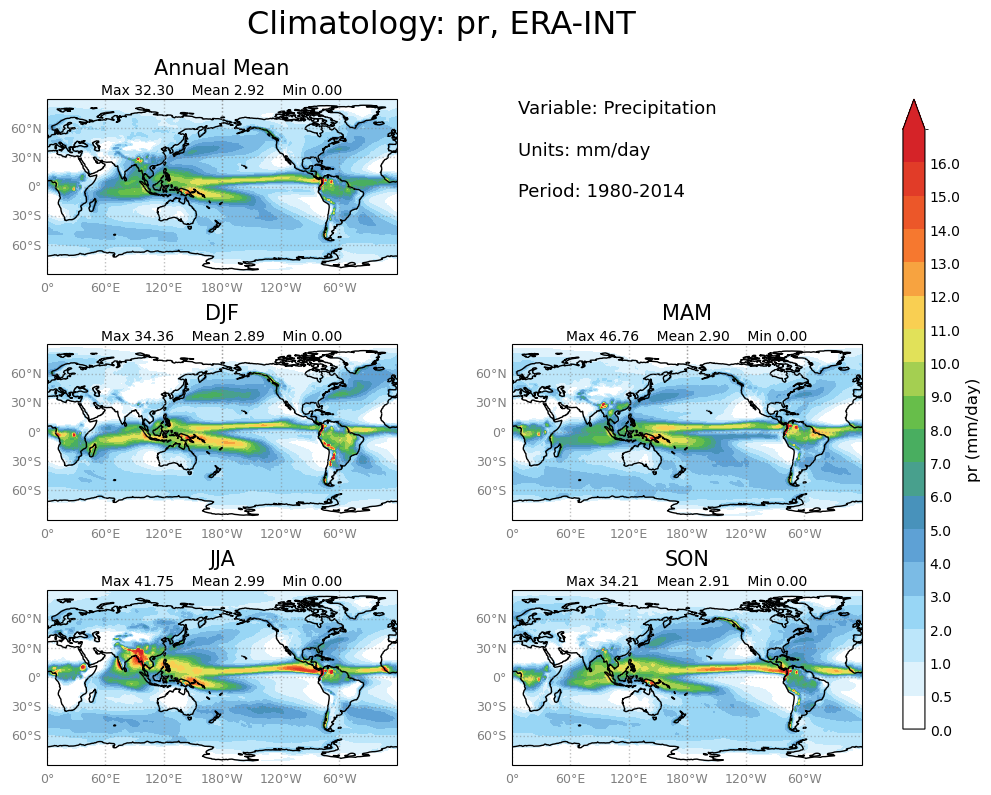

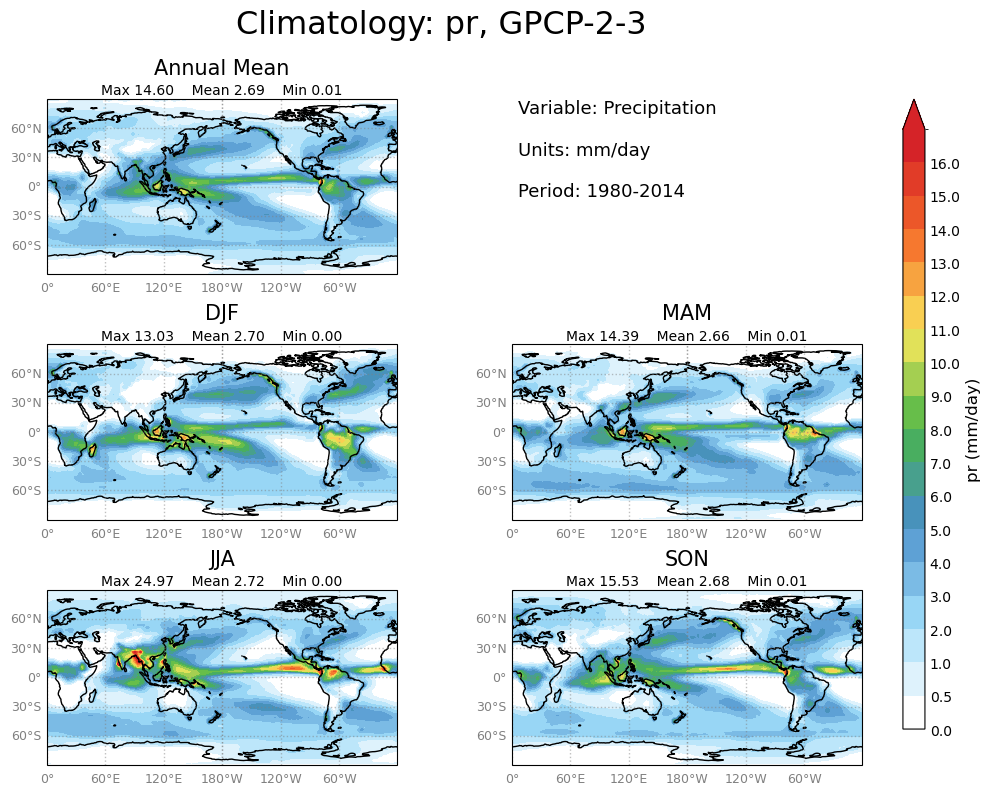

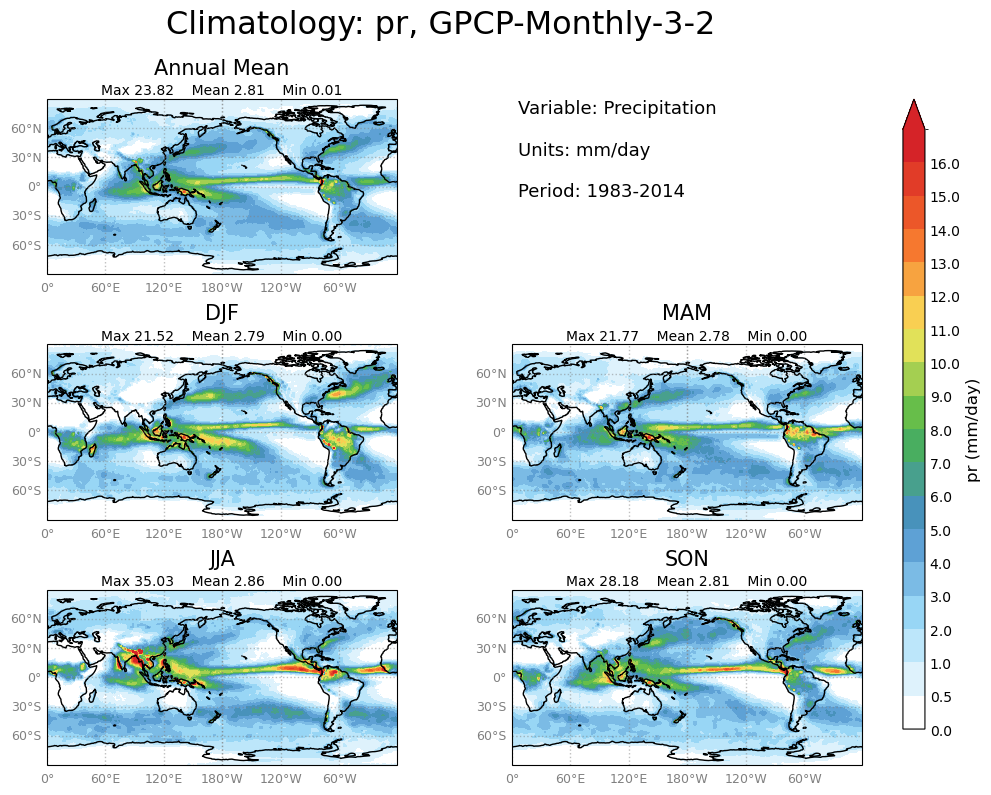

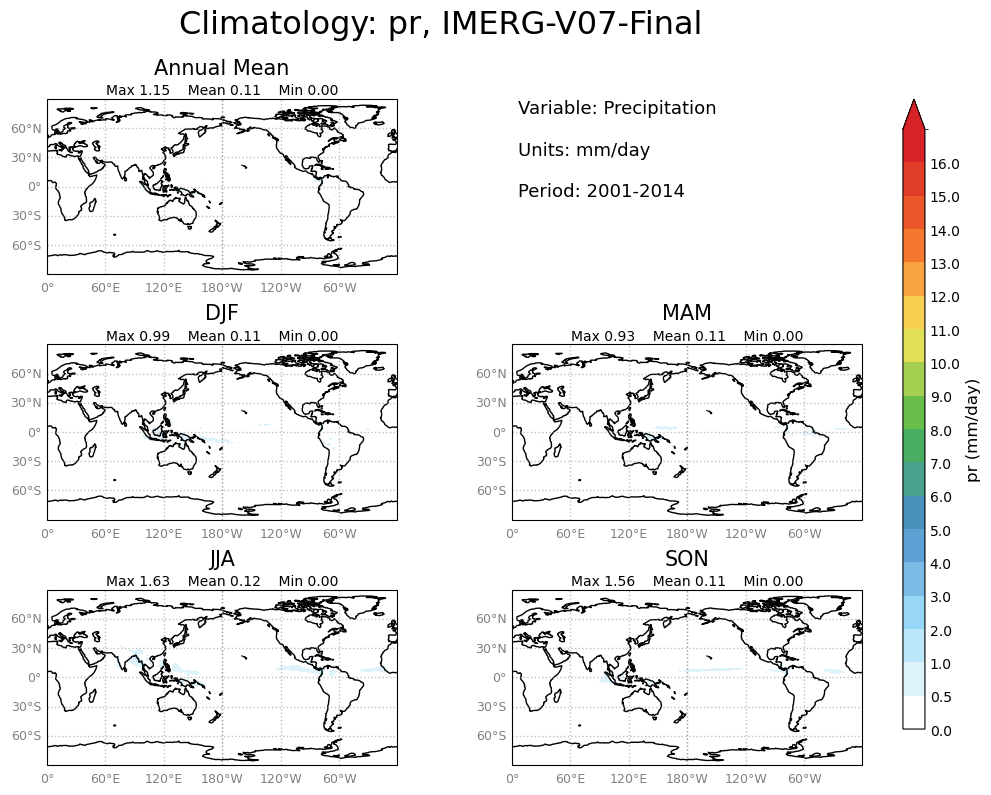

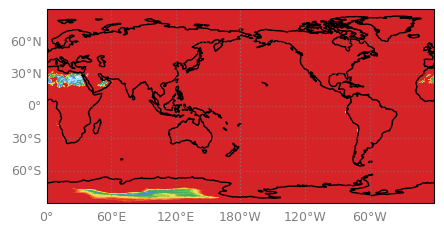

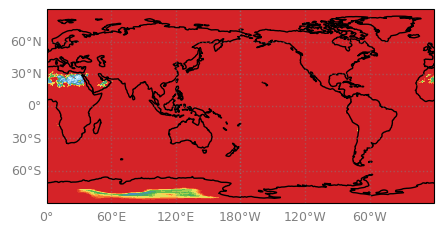

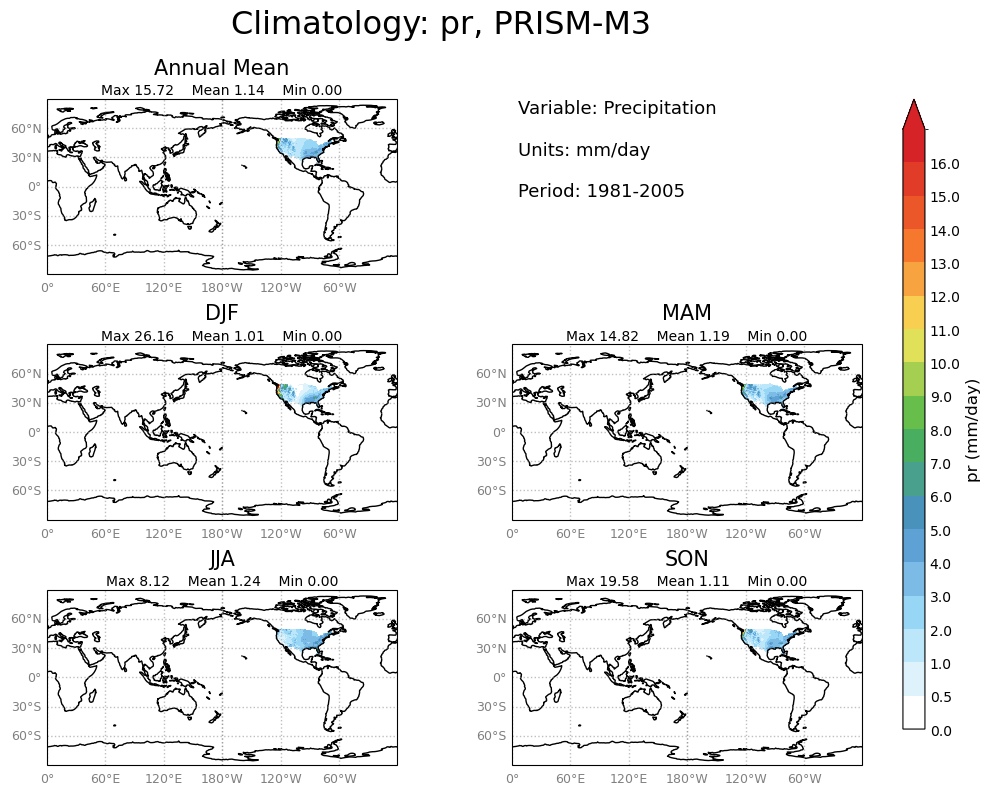

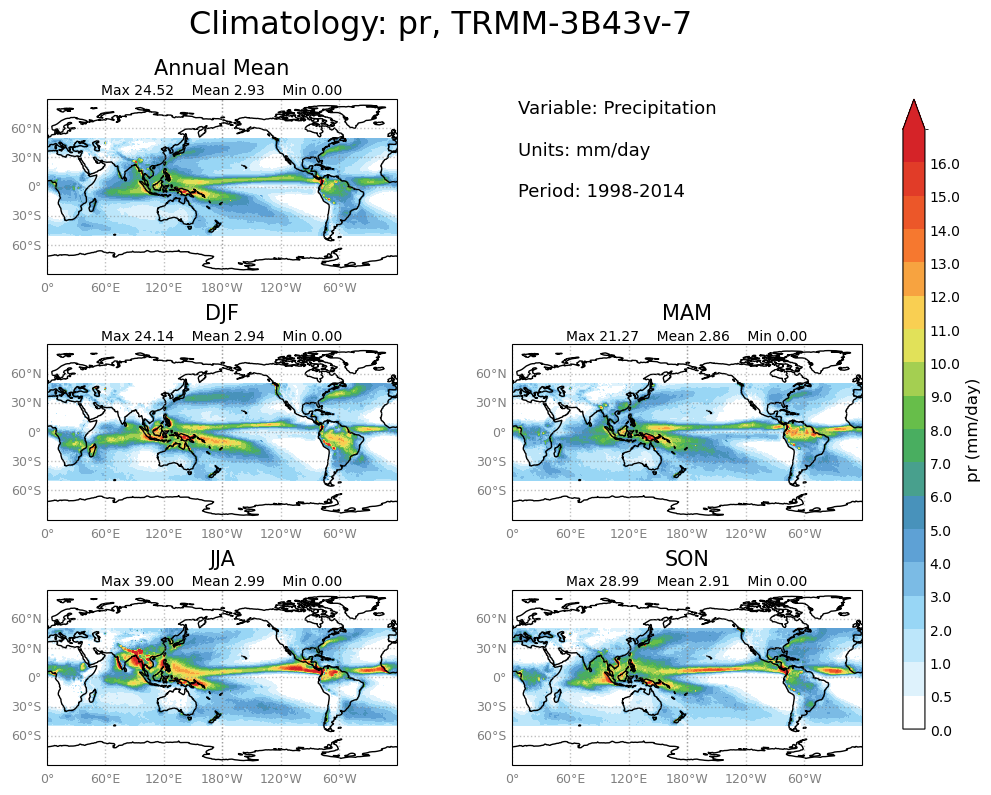

In [ ]:
encountered_variables = set()
ac_ref_dict = multi_level_dict()
ac_model_run_dict = multi_level_dict()
metrics_dict = multi_level_dict()



all_ref_variables = True

if all_ref_variables:
    variables = sorted(list(refs_dict.keys()))

variables_level_dict = get_unique_bases(variables)
variables_unique = list(variables_level_dict.keys())

"""
#target_ref = None
#target_ref = "CERES-EBAF-4-2"
target_ref = "ERA-5"

if target_ref == "ERA-5":
    variables_unique = era5_vars
    refs_dict = grouped_files
"""

print('variables_unique:', variables_unique)
print('variables_level_dict:', variables_level_dict)


def process_references(var, refs, rad_diagnostic_variables, levels, common_grid, start, end, version, interim_output_path_dict):
    for ref in refs:
        print(f"=== var, ref: {var}, {ref}")
        try:
        #if 1:
            process_dataset(
                var, ref, refs_dict, ac_ref_dict, rad_diagnostic_variables, 
                encountered_variables, levels, common_grid, interim_output_path_dict["ref"], data_type="ref",
                start=start, end=end,     
                repair_time_axis=True,
                overwrite_output_ac=True,
                version=version
            )
        
        except Exception as e:
            # Log the error to a file
            logging.error(f"Error for {var} {ref}: {str(e)}")
            print(f"Error logged for {var} {ref}")
            print(f'Error from process_references for {var} {ref}:', e)


def process_models(var, models, models_runs_dict, rad_diagnostic_variables, levels, common_grid, refs, start, end, version, interim_output_path_dict):
    for model in models:
        for run in models_runs_dict[model]:
            try:
                process_dataset(
                    var, (model, run), models_dict, ac_model_run_dict, 
                    rad_diagnostic_variables, encountered_variables, levels, common_grid, 
                    interim_output_path_dict["model"], data_type="model",
                    start=start, end=end,
                    version=version
                )
                for level in levels:
                    ac_model_run_level_interp = ac_model_run_dict[var][model][run][level]
                    calculate_and_save_metrics(var, model, run, level, regions, refs, ac_ref_dict, ac_model_run_level_interp, output_path, refs_dict, metrics_dict)
            except Exception as e:
                print(f'Error from process_models for {var} {model} {run}:', e)

    for level in levels:
        if level is None:
             var_key = var
        else:
             var_key = f"{var}-{level}"
        write_to_json(metrics_dict[var_key], os.path.join(output_path, f"output_{var_key}.json"))


def main():  
    # Set version identifier using the current date if not provided
    version = datetime.datetime.now().strftime("v%Y%m%d")
    print("version:", version)

    #start = "1981-01"
    #end = "2004-12"
    
    start = "1980-01"
    end = "2014-12"

    syear = start.split("-")[0]
    eyear = end.split("-")[0]

    interim_output_path_dict = {
        "ref": {
            "path_ac": f"/global/cfs/projectdirs/m4581/PMP/pmp_reference/obs4MIPs_clims_{syear}-{eyear}/%(var)/gn",
            "path_ac_interp": f"/global/cfs/projectdirs/m4581/PMP/pmp_reference/obs4MIPs_clims_{syear}-{eyear}/%(var)/gr"
        },
        "model": {
            "path_ac": f"/global/cfs/cdirs/m4581/lee1043/work/cdat/pmp/mean_climate/mean_climate_workflow_refactorization/output/clim_models_{syear}-{eyear}/%(var)/gn",
            "path_ac_interp": f"/global/cfs/cdirs/m4581/lee1043/work/cdat/pmp/mean_climate/mean_climate_workflow_refactorization/output/clim_models_{syear}-{eyear}/%(var)/gr"
        }
    }
    
    #variables_unique = ["pr"]
    #variables_unique = ["psl"]
    #variables_unique = ["ta", "ua", "va", "zg"]
    #variables_unique = ["tas", "ta"]
    #variables_unique = ["ta"]
    variables_unique.remove("pr")

    for var in variables_unique:
        try:
            print("var:", var)
            encountered_variables.add(var)
            levels = variables_level_dict[var]

            print("levels:", levels)

            if var in refs_dict:
                refs = refs_dict[var].keys()

                """
                if target_ref is not None:
                    if target_ref in refs:
                        refs = [target_ref]
                    else:
                        refs = []
                """
                process_references(var, refs, rad_diagnostic_variables, levels, common_grid, start, end, version, interim_output_path_dict)

            # process_models(var, models, models_runs_dict, rad_diagnostic_variables, levels, common_grid, refs, start, end, version)
        
        except Exception as e:
            print(f'Error from main for {var}:', e)            
        
if __name__ == "__main__":
    main()


In [16]:
print_dict(refs_dict)

{
    "hfls": {
        "ERA-INT": {
            "filename": "hfls_mon_ERA-INT_PCMDI_gn_197901-201903.nc",
            "obs4MIPs-template": "ECMWF/ERA-INT/mon/hfls/gn/v20210727/hfls_mon_ERA-INT_PCMDI_gn_197901-201903.nc",
            "path": "/global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/ECMWF/ERA-INT/mon/hfls/gn/v20210727",
            "pcmdi-internal-template": "/global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/ECMWF/ERA-INT/mon/hfls/gn/v20210727/hfls_mon_ERA-INT_PCMDI_gn_197901-201903.nc",
            "period": "197901-201903",
            "template": "/global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/ECMWF/ERA-INT/mon/hfls/gn/v20210727/hfls_mon_ERA-INT_PCMDI_gn_197901-201903.nc"
        },
        "TropFlux-1-0": {
            "filename": "hfls_mon_TropFlux-1-0_PCMDI_gn_197901-201707.nc",
            "obs4MIPs-template": "ESSO/TropFlux-1-0/mon/hfls/gn/v20210727/hfls_mon_TropFlux-1-0_PCMDI_gn_197901-201707.nc",
            "path": "/global/cfs/projectdirs/m4581/obs4MIPs

In [17]:
print_dict(models_dict)

{
    "hfls": {
        "model-a": {
            "r1": {
                "filename": "model-a_r1_hfls_blabla.nc",
                "path": "/home/data/model-a/hfls",
                "template": "/home/data/model-a/hfls/model-a_r1_hfls_blabla.nc",
                "varname": "hfls"
            },
            "r2": {
                "filename": "model-a_r2_hfls_blabla.nc",
                "path": "/home/data/model-a/hfls",
                "template": "/home/data/model-a/hfls/model-a_r2_hfls_blabla.nc",
                "varname": "hfls"
            }
        },
        "model-b": {
            "r1": {
                "filename": "model-b_r1_hfls_blabla.nc",
                "path": "/home/data/model-b/hfls",
                "template": "/home/data/model-b/hfls/model-b_r1_hfls_blabla.nc",
                "varname": "hfls"
            },
            "r2": {
                "filename": "model-b_r2_hfls_blabla.nc",
                "path": "/home/data/model-b/hfls",
                "template": "/